In [ ]:
import pandas as pd
import os

# Read each data file into a DataFrame
file_paths = ['./Q_1.dataset/a.us.txt', './Q_1.dataset/aa.us.txt','./Q_1.dataset/aaba.us.txt','./Q_1.dataset/aapl.us.txt','./Q_1.dataset/abc.us.txt']
dfs = [pd.read_csv(file_path, parse_dates=['Date'], index_col='Date') for file_path in file_paths]

# Find the intersection of dates among all data frames
common_dates = set(dfs[0].index)
for df in dfs[1:]:
    common_dates = common_dates.intersection(df.index)

# Convert common_dates to a list and sort them
common_dates = sorted(list(common_dates))

# Filter each data frame to contain only the common dates
for i, df in enumerate(dfs):
    dfs[i] = df.loc[common_dates]

    # Save the filtered DataFrame to a new CSV file
    output_file_path = f'filtered_{os.path.basename(file_paths[i])}'  # Change the output file name as needed
    dfs[i].to_csv(output_file_path)

# Now, dfs list contains filtered DataFrames and each one is saved to a new CSV file


Processing Stock a - 1/5


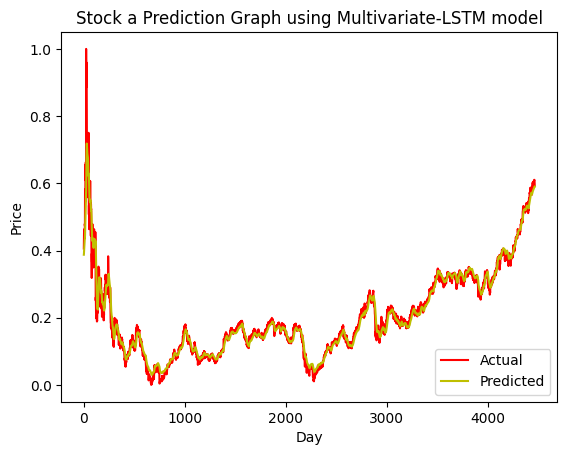

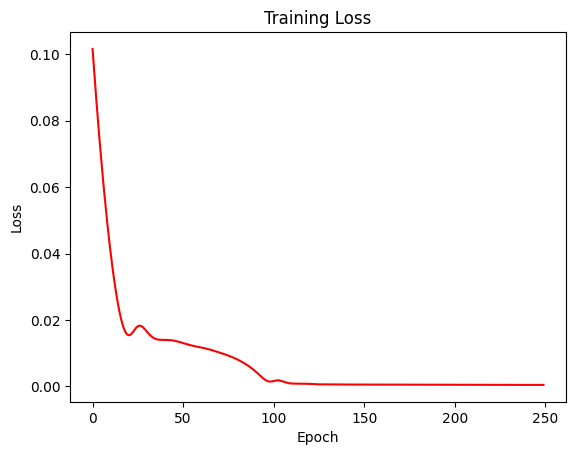

Processing Stock aa - 2/5


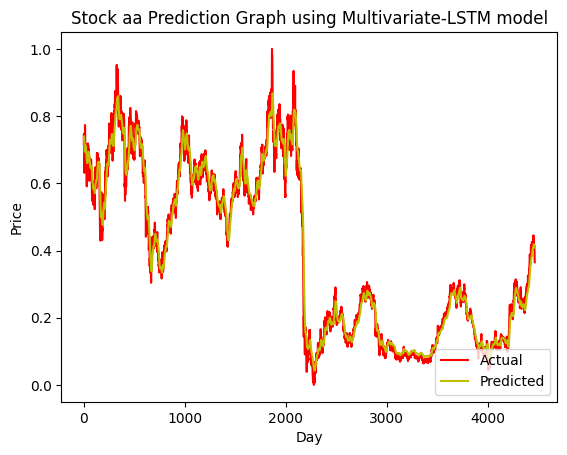

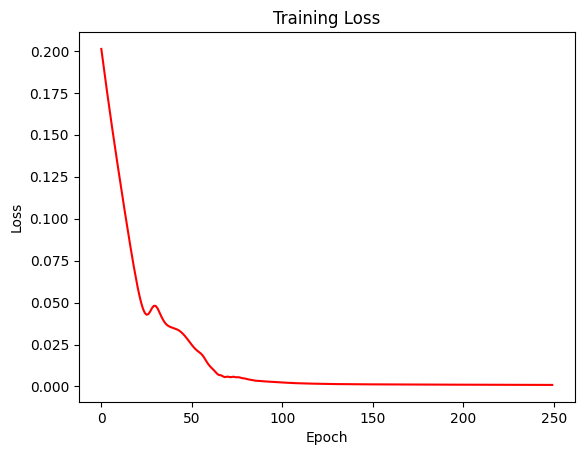

Processing Stock aaba - 3/5


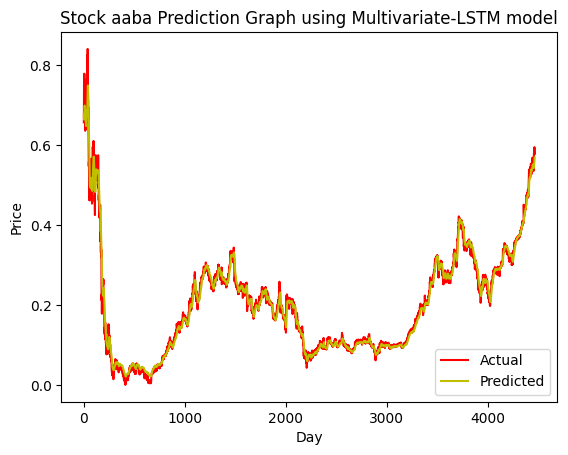

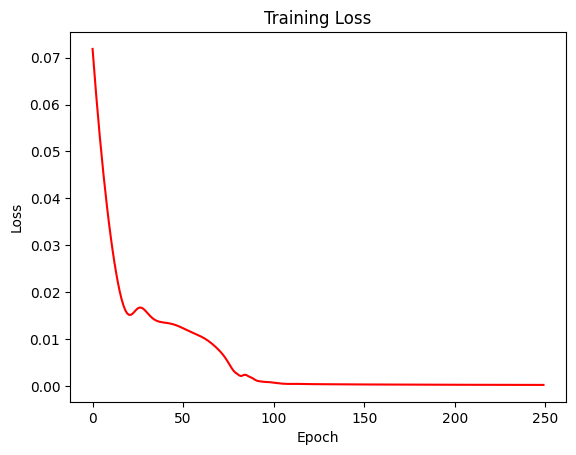

Processing Stock aapl - 4/5


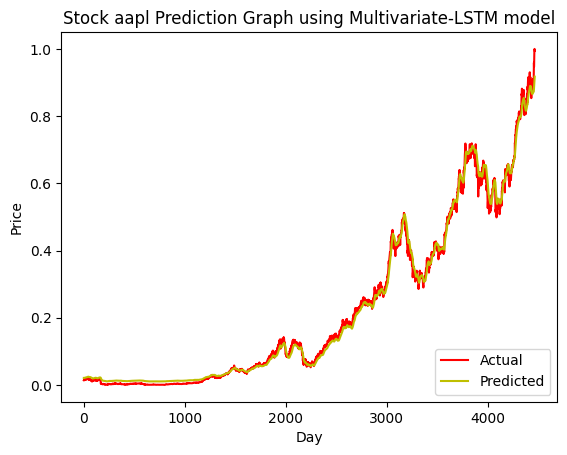

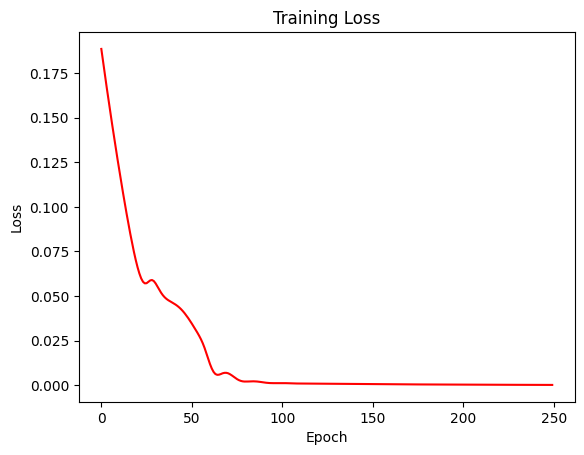

Processing Stock abc - 5/5


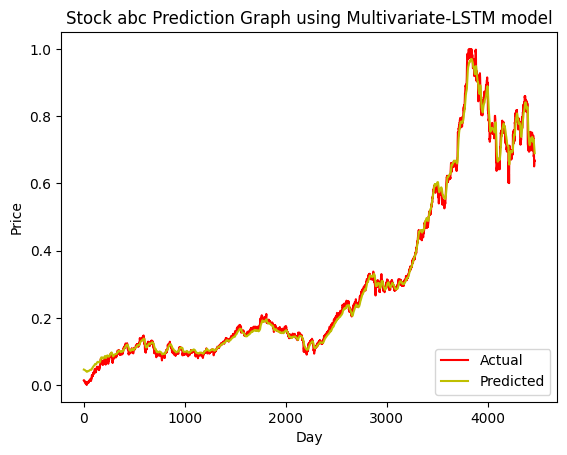

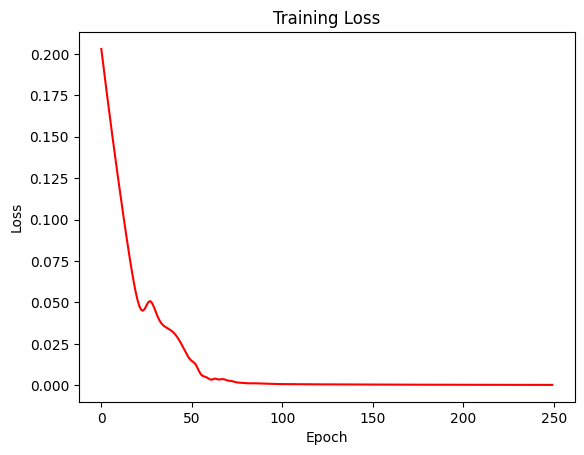

Results for Stock a:
MSE = 0.00044271533
RMSE = 0.021040801615207834
R-Squared Score = 0.9735828055467582
Results for Stock aa:
MSE = 0.0009267598
RMSE = 0.030442729714856284
R-Squared Score = 0.9854723658601163
Results for Stock aaba:
MSE = 0.00022657873
RMSE = 0.015052532458630901
R-Squared Score = 0.987209180069852
Results for Stock aapl:
MSE = 0.00022341152
RMSE = 0.014946957002032153
R-Squared Score = 0.99648280202928
Results for Stock abc:
MSE = 0.00021080553
RMSE = 0.014519143712778453
R-Squared Score = 0.9969653212973267


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import os  # Import the os module

# Define the LSTM model
class MultiStockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultiStockLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(1, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Load the CSV files into separate DataFrames
file_paths = ['./Q_1.dataset/a.us.txt', './Q_1.dataset/aa.us.txt','./Q_1.dataset/aaba.us.txt','./Q_1.dataset/aapl.us.txt','./Q_1.dataset/abc.us.txt']  # Replace with your file paths

# file_paths = ['a.us.txt', 'aa.us.txt', 'aamc.us.txt']  # Replace with your file paths
dfs = [pd.read_csv(file_path, parse_dates=True, index_col=0) for file_path in file_paths]

# Combine data into a single DataFrame
combined_df = pd.concat([df['Close'].rename(os.path.basename(file_path).split('.')[0]) for df, file_path in zip(dfs, file_paths)], axis=1)

# Prepare a list to store results
results = []

# Iterate through each DataFrame
for i, (stock_name, df) in enumerate(combined_df.items()):
    print(f"Processing Stock {stock_name} - {i+1}/{len(combined_df.columns)}")

    # Extract closing prices from DataFrame
    closing_prices = df.values.reshape(-1, 1)

    # Normalize closing prices
    scaler = MinMaxScaler()
    closing_prices_scaled = scaler.fit_transform(closing_prices)

    # Prepare the data
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length])
        return np.array(X), np.array(y)

    seq_length = 50
    X, y = create_sequences(closing_prices_scaled, seq_length)

    # Convert data to PyTorch tensors
    X = torch.Tensor(X)
    y = torch.Tensor(y)

    # Define hyperparameters
    input_dim = X.shape[-1]
    hidden_dim = 40
    output_dim = X.shape[-1]
    lr = 1e-3
    batch_size = 64
    num_epochs = 250

    # Initialize the model, loss function, and optimizer
    model = MultiStockLSTM(input_dim, hidden_dim, output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training the model
    train_loss = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Prediction
    model.eval()
    with torch.no_grad():
        test_output = model(X)
        # Check for NaN values
        if np.isnan(y.numpy()).any() or np.isnan(test_output.numpy()).any():
            print("Warning: NaN values detected in the input or output.")
            # Handle NaN values by removing rows with NaN values
            nan_indices = np.isnan(y.numpy()) | np.isnan(test_output.numpy())
            nan_indices = np.broadcast_to(nan_indices, X.shape)
            X_clean = X[~nan_indices]
            y_clean = y[~nan_indices]
            test_output_clean = test_output[~nan_indices]
            
            # Calculate metrics on clean data
            mse = mean_squared_error(y_clean.numpy(), test_output_clean.numpy())
            rmse = sqrt(mse)
            r2 = r2_score(y_clean.numpy(), test_output_clean.numpy())
        else:
            # Calculate metrics on original data
            mse = mean_squared_error(y.numpy(), test_output.numpy())
            rmse = sqrt(mse)
            r2 = r2_score(y.numpy(), test_output.numpy())

        results.append((mse, rmse, r2))

    # Plotting
    plt.plot(y.numpy()[:, 0], color='r')
    plt.plot(test_output.numpy()[:, 0], color='y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(f'Stock {stock_name} Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc='lower right')
    plt.show()

    # Plotting the training errors
    plt.plot(train_loss, color='r')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training Loss')
    plt.show()

# Display results
for i, (stock_name, _) in enumerate(combined_df.items()):
    print(f"Results for Stock {stock_name}:")
    print('MSE =', results[i][0])
    print('RMSE =', results[i][1])
    print('R-Squared Score =', results[i][2])
